# Sampling the World

Using a Random Walk Metropolis sampler and [data from Kaggle](https://www.kaggle.com/max-mind/world-cities-database), we are going to see if we can randomly stumble our way across the entire world!

#### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
from tqdm.notebook import tqdm
%matplotlib notebook

#### Get Longitude, Latitude and Population data from Kaggle

In [2]:
all_kaggle_world_data = pd.read_csv('worldcitiespop.csv')

C:\Users\lewis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(all_kaggle_world_data.shape)
all_kaggle_world_data.head(3)

(3173958, 7)


,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6,NaN,42.466667,1.500000


#### Process the raw Kaggle data

Examining our raw data, we can see that we don't always have population data - we can exclude these points from our work. We also have columns that aren't of particular interest to us, such as city name, so we can drop these columns completely too.

In [4]:
pop_exists_df = all_kaggle_world_data[all_kaggle_world_data["Population"].notnull()]

In [5]:
long_lat_pop = pop_exists_df[["Longitude", "Latitude", "Population"]].reset_index(drop=True)
print(long_lat_pop.shape)
long_lat_pop.head(3)

(47980, 3)


,Longitude,Latitude,Population
0,1.516667,42.500000,20430.0
1,1.600000,42.566667,3292.0
2,1.583333,42.533333,11224.0


For clarity, we will also exclude any cities with very small populations. We should also ensure we do not have any duplicate entires and remove these if we do.

In [6]:
# remove cities with very low populations
long_lat_pop = long_lat_pop[long_lat_pop["Population"]>100000]
# drop duplicates
long_lat_pop = long_lat_pop.drop_duplicates().reset_index(drop=True)

long_lat_pop.shape

(3524, 3)

#### Plot our processed data

We can now take our first look at our data! We can see that we have population data for cities around the entire world, with the data nicely forming an outline of the world map we are used to seeing.

<IPython.core.display.Javascript object>


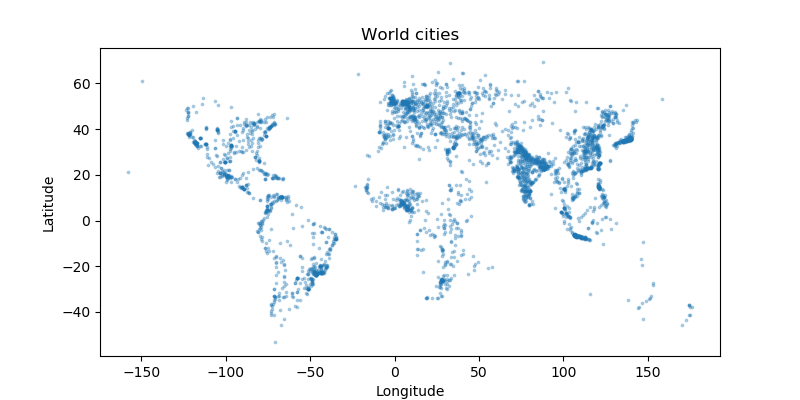

In [7]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('World cities')

plt.scatter(long_lat_pop["Longitude"], long_lat_pop["Latitude"], s=3, alpha=0.3)

## Create a probability density function (PDF) that describes the world's population spread

To simplify things, we are going to assume that the population density of each city individually follows a circular normal distribution, with more people living in the city centre than in the suburbs. We will also assume that the spread (standard deviation) of each city is the same i.e. for each city, we will assume that $X$% of the the population lives within $Y$km of the city centre.

We will start our calculation with the circular normal distribution function:

\begin{equation}
f(x, y; \mu_{x,y}, \sigma_{x,y}) = \frac{1}{2\pi\sigma_x\sigma_y} \exp\bigg(-\frac{1}{2} \bigg[
    \big(\frac{x - \mu_x}{\sigma_x}\big)^2 +
    \big(\frac{y - \mu_y}{\sigma_y}\big)^2
\bigg]\bigg)
\end{equation}

In our model, our $\mu_x$and $\mu_y$ will be our citys' longitiudes and latitudes, while the $\sigma_{x,y}$ will be the 'spread' of our cities. As we are assuming the population density is circularly symmetric for each city, the above calculation simplifies to:

\begin{equation}
f(x, y; \mu_{x, y}, \sigma) = \frac{1}{2\pi\sigma^2} \exp\bigg(-\frac{1}{2\sigma^2} \bigg[
    (x - \mu_x)^2 +
    (y - \mu_y)^2
\bigg]\bigg)
\end{equation}

Our total, worldwide probability density function is then given by summing the pdfs for each individual city $i$ and weighting them by their population:

\begin{equation}
F(x, y) = \Sigma_i^n\frac{population_i}{2\pi\sigma_i^2} \exp\bigg(-\frac{1}{2\sigma_i^2} \bigg[
    (x - \mu_{x_i})^2 +
    (y - \mu_{y_i})^2
\bigg]\bigg)
\end{equation}

<font color="red">**Simplification warning** - in addition to assuming that all cities have the same $\sigma$ population spread, we will also model this spread as larger than reality. This change is in part to account for the fact that we will have people living outside cities, but it is also to allow us to more easily travel between these city nodes in our random walk later on.</font>

In [8]:
# change below to change size of sigma in km (68% of a city's pop will live within this radius)
sigma_km = 50

# convert from km to degrees - Earth's circumference is ~ 40,075km
earth_diameter_km = 40075
sigma_degrees = (sigma_km / earth_diameter_km ) * 360

In [9]:
def PDF(x, y, sig=sigma_degrees, loc_df=long_lat_pop):
    pdf = 0
    for i in range(loc_df.shape[0]):
        pdf += (loc_df["Population"][i]/(2*math.pi*sig**2)) * math.exp(
            -(1/(2*sig**2)) * ( (x-loc_df["Longitude"][i])**2 + (y-loc_df["Latitude"][i])**2 ))
    return pdf

#### Evaludate pdf likelihood at sample locations - big cities should have higher pdf values than the middle of nowhere!

In [10]:
print("PDF evaluated near London: {:.2e}".format(PDF(-0.12,51.5)))
print("PDF evaluated near the Shetlands: {:.2e}".format(PDF(-1.3, 60.5)))
print("PDF evaluated in the middle of the atlantic: {:.2e}".format(PDF(-43, 33)))

PDF evaluated near London: 6.38e+06
PDF evaluated near the Shetlands: 1.87e-08
PDF evaluated in the middle of the atlantic: 0.00e+00


#### Check if the PDF function approximately recreates city our city distribution

<font color="red">**Runtime warning** - the PDF takes a non-negligible amount of time to solve, so this step may take a few minutes if you try to evaluate it at more than a few hundred locations.</font>

In [11]:
# choose on longitudes/latitudes you want to test (e.g. only Europe)
longitudes_even_spaced = np.arange(-15, 45.1, 2)
latitudes_even_spaced = np.arange(30, 65.1, 2)

n_long = len(longitudes_even_spaced)
n_lat = len(latitudes_even_spaced)

likelihood = np.empty(shape=(n_long, n_lat))

In [12]:
# evaluate the pdf at our sample longitudes and latitudes
for long_idx, long in enumerate(tqdm(longitudes_even_spaced)):
    for lat_idx, lat in enumerate(latitudes_even_spaced):
        likelihood[long_idx, lat_idx] = PDF(long, lat)

<IPython.core.display.Javascript object>


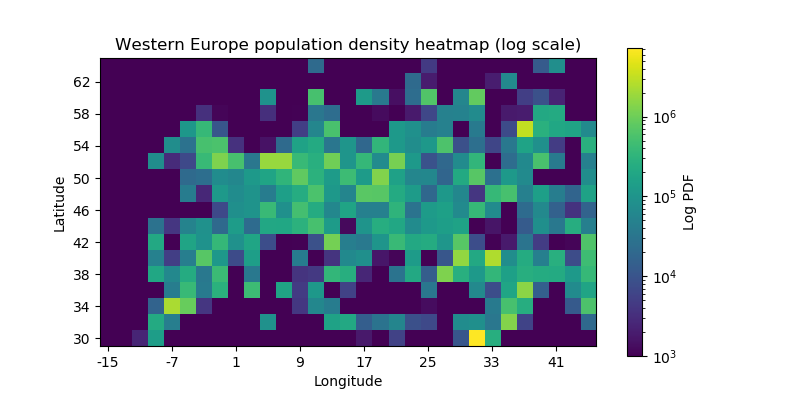

In [25]:
from matplotlib.colors import LogNorm

# create our figure
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)

# label axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Western Europe population density heatmap (log scale)')

# change axis ticks to show long and lat again
ax.set_xticks(np.arange(n_long)[::4])
ax.set_yticks(np.arange(n_lat)[::2])
ax.set_xticklabels(longitudes_even_spaced[::4].astype(int))
ax.set_yticklabels(latitudes_even_spaced[::2].astype(int))

# plot data (note - transposing and flipping y-axis to gain same view as the original map)
plt.imshow(likelihood.T, norm=LogNorm(vmin=1e3))
plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label("Log PDF")

## Random Walk Metropolis

We will now write the Random Walk Metropolis (RWM) algorithm that will take us around the map! The RWM is one of the most common Markov Chain Monte Carlo (MCMC) algorithms in practical use today.

The steps involved in this process are:

- Propose a new location to move to. This proposal will follow a circular normal distribution similar to we had before, but this time it will be centred on our current location and it's width will be determined by our step size, $\tau$.


- The PDF is then evaluated at both the current and proposed location and the ratio of these values, $r$, is recorded.


- Compare $r$ with a random number, $u$, drawn from a uniform distribution between 0 and 1


- If $r \ge u$ then we move, otherwise we remain at our current position


- This process is repeated until we deem to have converged i.e. the sampling distribution stops changing (within a certain tolerance)

#### What might be a sensible step size in degrees of longitude and latitude?

In [14]:
# define step size in km
step_size_km = 500

# convert from km to degrees - Earth's circumference is ~ 40,075km
earth_diameter_km = 40075
step_size_degrees = (step_size_km / earth_diameter_km ) * 360

step_size_degrees

4.491578290704928

#### Write functions decide whether to move to proposed location of stay put

In [15]:
def propose_new_location(x, y, tau=5):
    x_new, y_new = np.random.multivariate_normal([x, y], np.eye(2)*tau, 1)[0]  
    return x_new, y_new

In [16]:
def new_location(x, y, tau=5):
    x_new, y_new = propose_new_location(x, y, tau)
    
    # calculate pdf likelihood at current and proposed location
    pdf_old = PDF(x, y)
    pdf_new = PDF(x_new, y_new)
    
    # compare r and u and decide if we move or stay at our current location
    u = np.random.uniform(0,1)
    try:
        r = pdf_new / pdf_old
    except ZeroDivisionError:
        r = u + 1e-10
    
    return (x_new, y_new) if r >= u else (x, y)

#### Get chain of MCMC samples to see how well we traverse the map

In [17]:
def generate_chain(x=np.random.uniform(-150, 150), y=np.random.uniform(-60, 60), num_iter=10, tau=5):
    
    # initiate chain that will record our longitudes and latitudes as we move through space
    long_lat_chain = [[x, y]]
    
    for i in range(num_iter):
        x, y = new_location(long_lat_chain[i][0], long_lat_chain[i][1], tau)
        long_lat_chain.append([x, y])
        
    return long_lat_chain

#### Generate test MCMC chain starting in an area where there are cities nearby

In [71]:
big_pops_df = pd.DataFrame(columns=("Area", "Longitude", "Latitude"))
big_pops_df.loc[len(big_pops_df)] = ["Europe", 0, 50]
big_pops_df.loc[len(big_pops_df)] = ["West Africa", 6, 8]
big_pops_df.loc[len(big_pops_df)] = ["India", 75, 25]
big_pops_df.loc[len(big_pops_df)] = ["Japan", 138, 36]
big_pops_df.loc[len(big_pops_df)] = ["Indonesia", 110, -6]
big_pops_df.loc[len(big_pops_df)] = ["Brazil", -47, -22]
big_pops_df.loc[len(big_pops_df)] = ["East US", -73, 42]

In [74]:
%%time

N = 100    # number of iterations for each chain
step = 10  # step size in degrees

chain_dict = {}
for idx in tqdm(range(big_pops_df.shape[0])):
      
    x_start, y_start = list(big_pops_df[["Longitude", "Latitude"]].iloc[idx])
    chain_dict[ big_pops_df[["Area"]].iloc[idx].values[0] ] = generate_chain(x=x_start, y=y_start, num_iter=N, tau=step)


Wall time: 3min 55s


<IPython.core.display.Javascript object>


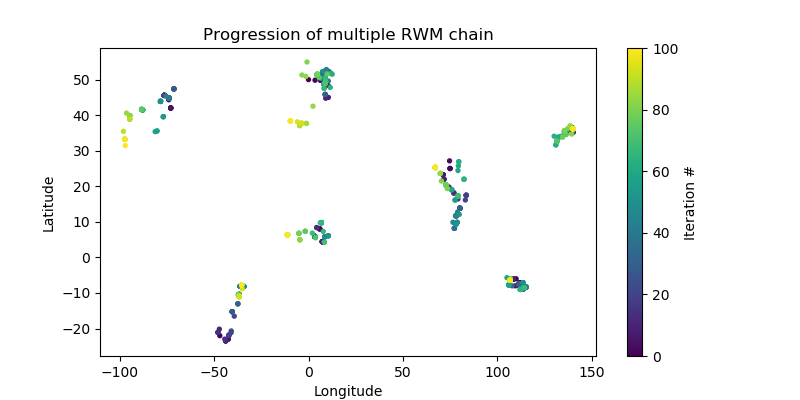

In [91]:
# create our figure
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)

# label axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Progression of multiple RWM chain')

for key in chain_dict:
    
    xs = np.array(chain_dict[key])[:,0]
    ys = np.array(chain_dict[key])[:,1]
    
    # plot the steps taken in our random walk colour coded by our iteration# (+1 as we have our starting point too)
    plt.scatter(xs, ys, c=np.arange(0, N+1), s=8)

cb = plt.colorbar()
cb.set_label("Iteration #")

In [18]:
x_europe = 0
y_europe = 50
num_iterations = 20
step_deg = 10

In [27]:
%%time
chain = generate_chain(x=x_europe, y=y_europe, num_iter=num_iterations, tau=step_deg)

Wall time: 6.62 s


In [20]:
# get chain data as a numpy array for easier plotting
chain_np = np.array(chain)

<IPython.core.display.Javascript object>


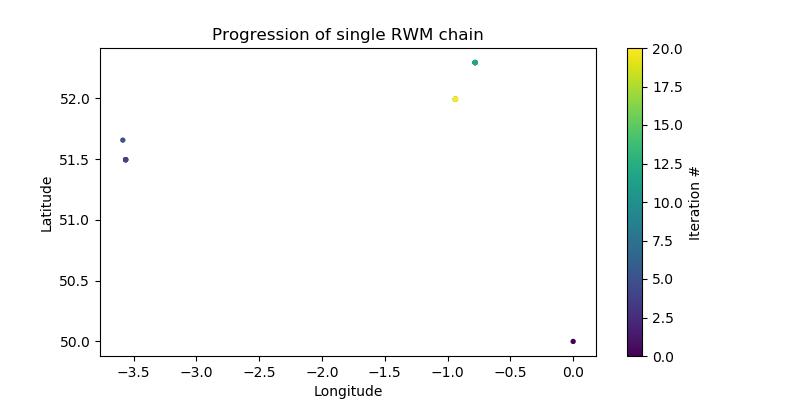

In [78]:
# create our figure
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)

# label axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Progression of single RWM chain')

# plot the steps taken in our random walk colour coded by our iteration# (+1 as we have our starting point too)
plt.scatter(chain_np[:,0], chain_np[:,1], c=np.arange(0, num_iterations+1), s=8, label="test")

cb = plt.colorbar()
cb.set_label("Iteration #")